In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [3]:
# Data Wrangling
def wrangle(x):
    df = pd.read_csv(x,parse_dates = ['Date']
                     , index_col = "Date"
                    )
    #Sorting Index
    df.sort_index(ascending=True,inplace=True)
    

    #Fixing times change frome objects and turn everything to seconds!!!!!
    df.replace('--','0', inplace=True)
    test = df[df['Avg Pace'] == '--'].index
    df.drop(test,inplace=True)
    
    def split_mil(x):
        y = x.split('.')[0]
        if len(y) < 7:
            real = '00:' + y
            return real
        else:
            return y
            
    df['Time'] = df['Time'].apply(split_mil)
    df['Best Lap Time'] = df['Best Lap Time'].apply(split_mil)
    
    def replacement(x):
        t = x.replace(':','.')
        return t
    
    df['Avg Pace'] = df['Avg Pace'].apply(replacement)
    df['Best Pace'] = df['Best Pace'].apply(replacement)
    df['Best Lap Time'] = df['Best Lap Time'].apply(replacement)
    df['Time'] = df['Time'].apply(replacement)

    def time_to_seconds(x):
        y = (int(x.split('.')[0])*3600) + (int(x.split('.')[1])*60) + (int(x.split('.')[-1]))
        return y

    df['Time'] = df['Time'].apply(time_to_seconds)
    df['Best Lap Time'] = df['Best Lap Time'].apply(time_to_seconds)

    def time_to_seconds2(x):
        y = (int(x.split('.')[0])*60) + (int(x.split('.')[-1]))
        return y
    df['Best Pace'] = df['Best Pace'].apply(time_to_seconds2)
    df['Avg Pace'] = df['Avg Pace'].apply(time_to_seconds2)
    
    def replacement2(x):
        t1= x.replace(',','')
        return t1
    df['Calories'] = df['Calories'].apply(replacement2).astype(float)
    df['Elev Gain'] = df['Elev Gain'].apply(replacement2).astype(float)
    df['Elev Loss'] = df['Elev Loss'].apply(replacement2).astype(float)
    
    #Fixing Other 'objects'
    df['Avg HR'] = df['Avg HR'].astype(float)
    df['Max HR'] = df['Max HR'].astype(float)
    df['Avg Run Cadence'] = df['Avg Run Cadence'].astype(float)
    df['Max Run Cadence'] = df['Max Run Cadence'].astype(float)
    
    #Engineering Features => Low Importance So Dropped after creating them.
    df['Running'] = 1
    df.loc[df['Activity Type'] != 'Running', 'Running'] = 0

    df['Treadmill Running'] = 1
    df.loc[df['Activity Type'] != 'Treadmill Running', 'Treadmill Running'] = 0

    df['Cardio'] = 1
    df.loc[df['Activity Type'] != 'Cardio', 'Cardio'] = 0
    
    df['Change in HR'] = df['Max HR'] - 60
    #df.drop(columns = ['Activity Type', 'Title'],inplace=True)
    df.drop(columns = ['Activity Type', 'Title', 'Number of Laps'],inplace=True)
    
    return df


df = wrangle('https://raw.githubusercontent.com/mramputatoes/Lambda_Projects/main/Running/activity_log.csv')
print(df.shape)
df.head()

(689, 17)


,Distance,Calories,Time,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Running,Treadmill Running,Cardio,Change in HR
Date,,,,,,,,,,,,,,,,,
2018-05-29 18:53:00,4.02,314.0,1772,150.0,173.0,170.0,178.0,441,376,197.0,204.0,1.29,0,1,0,0,113.0
2018-05-30 18:30:00,4.15,383.0,1828,147.0,164.0,168.0,176.0,440,354,180.0,177.0,1.30,0,1,0,0,104.0
2018-05-31 18:37:00,5.98,566.0,2717,149.0,175.0,168.0,246.0,454,365,322.0,322.0,1.27,0,1,0,0,115.0
2018-06-01 18:37:00,6.03,575.0,2544,159.0,175.0,170.0,180.0,422,339,382.0,387.0,1.35,0,1,0,0,115.0
2018-06-03 18:09:00,7.96,808.0,3333,170.0,184.0,170.0,182.0,419,274,669.0,679.0,1.35,0,1,0,0,124.0


In [4]:
# Creating our target feature, the one that the model will predict.
target = 'Calories' 
X=df.drop(columns=target)
y=df[target]

In [5]:
# Train, Validation, and Test split so we have stuff to train our model.
X_train, y_train = X[:-136], y[:-136]
X_val, y_val = X[-136:-68], y[-136:-68]
X_test, y_test = X[-68:], y[-68:]
print("Good to Go" if ((len(X_train) + len(X_test) + len(X_val)) == len(X)) else "Try Again" )
print("Good to Go, Again!" if ((len(y_train) + len(y_test) + len(y_val)) == len(y)) else "Try Again" )

Good to Go
Good to Go, Again!


In [6]:
# Baseline Calorie Predictor
y_pred = [y_train.mean()] *len(y_train)

print('Baseline MAE:',mean_absolute_error(y_train, y_pred))

Baseline MAE: 285.2749395864739


In [7]:
#Linear Regression Model
model_lr = LinearRegression()


model_lr.fit(X_train,y_train);

In [8]:
# Ridge Regression Model
model_r = Ridge()

model_r.fit(X_train, y_train);

In [9]:
# Random Forest Model
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)

model_rf.fit(X_train, y_train);

In [10]:
# XBG Model
model_xgb = XGBRegressor(random_state=42, n_jobs=-1)

model_xgb.fit(X_train, y_train);

In [11]:
# The Calorie Predictions for each model and their associated R^2's.
def check_metrics(model):
  print('Training MAE', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE', mean_absolute_error(y_val, model.predict(X_val)))
  print('Validation R^2', model.score(X_val, y_val))
  print()


models = [model_lr, model_r, model_rf, model_xgb]

for m in models:
  check_metrics(m)

Training MAE 66.04101122658429
Validation MAE 46.34070872156397
Validation R^2 0.7875682746511814

Training MAE 65.77329267866092
Validation MAE 45.8262509060435
Validation R^2 0.7928340773037098

Training MAE 12.389240506329115
Validation MAE 23.26264705882353
Validation R^2 0.9462544407270355

Training MAE 0.23472889632013563
Validation MAE 23.33621529971852
Validation R^2 0.9226957404669122



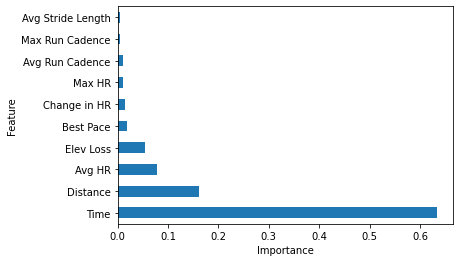

In [12]:
# The model with the lowest mean absolute error's feature importances.
importances = model_rf.feature_importances_
features = X_train.columns
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)
feature_importances.head(10).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel("Feature");

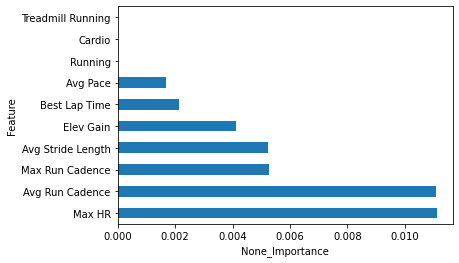

In [13]:
# The least important features.
importances = model_rf.feature_importances_
features = X_train.columns
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)
feature_importances.tail(10).plot(kind='barh')
plt.xlabel('None_Importance')
plt.ylabel("Feature");

In [14]:
from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(model_rf, 
                                  X_val, 
                                  y_val, 
                                  n_repeats=5, 
                                  n_jobs=-1, 
                                  random_state=42)

In [15]:
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']}

importances = pd.DataFrame(data, index=X_val.columns).sort_values(by='imp_mean')

importances.head()

,imp_mean,imp_std
Avg Pace,-0.000908,0.000164
Best Lap Time,-0.000679,0.000571
Best Pace,-0.000364,0.000268
Max Run Cadence,-0.000347,0.000205
Running,0.000000,0.000000


In [16]:
# Correlation Matrix to better visualize the data.
import seaborn as sns
corrmat = df.corr()
top_corr_features = corrmat.index

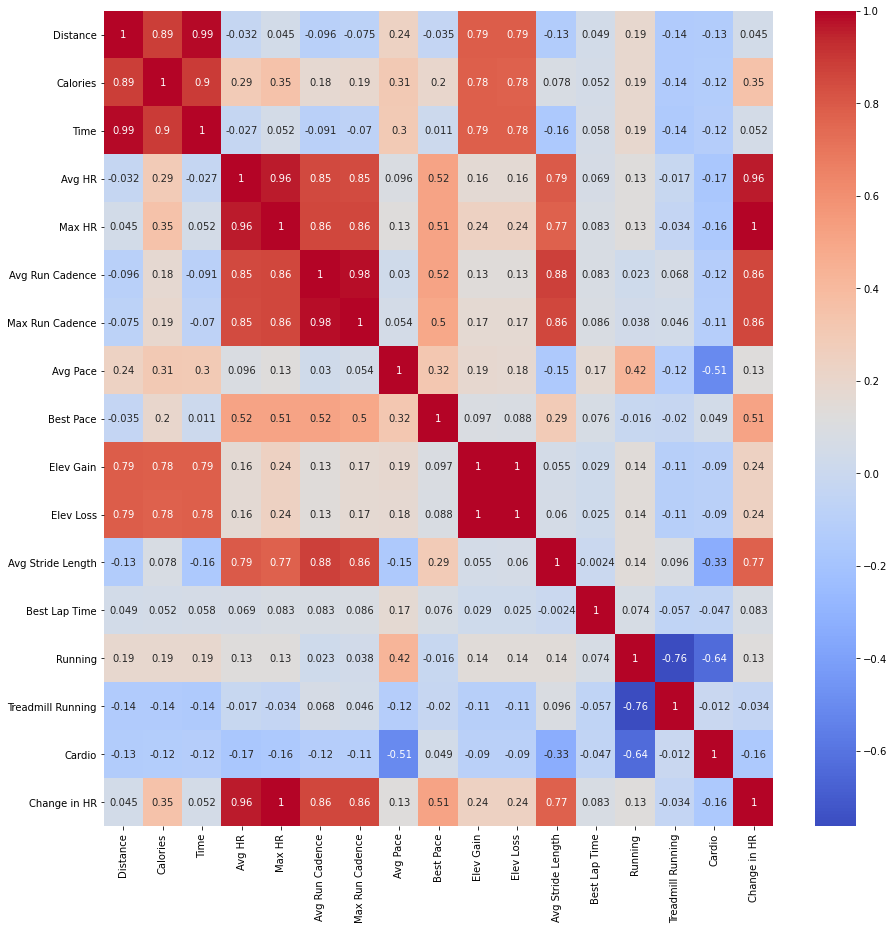

In [17]:
plt.figure(figsize=(15,15))

g=sns.heatmap(df[top_corr_features].corr(),annot=True, cmap='coolwarm')

In [18]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [19]:
feature = 'Time'

isolate = pdp_isolate(
    model_rf,
    dataset = X_val,
    model_features = X_test.columns,
    feature=feature,
    
)

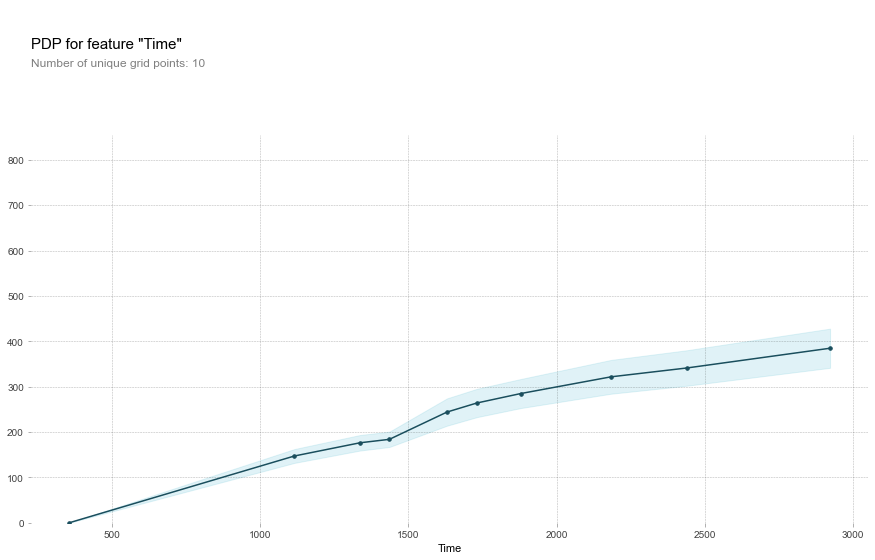

In [20]:
pdp_plot(isolate, feature_name=feature);

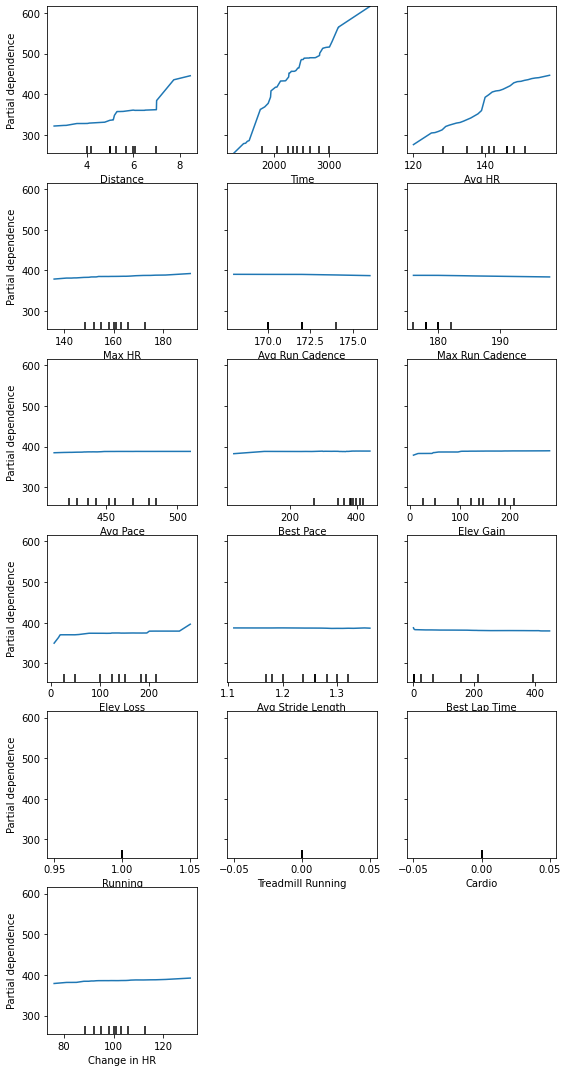

In [21]:
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 14))
plot_partial_dependence(model_rf, X_test, features = X_test.columns , target=0, ax=ax) 
fig.set_figwidth(8)
fig.set_figheight(15)
fig.tight_layout()

In [22]:
import shap

In [23]:
row = X_test.iloc[0]
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

In [24]:
row = X_test.sample(1)

explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

In [25]:
# The final DataFrame with the predicted Calories
predictions = pd.DataFrame(data=model_rf.predict(X_test), index=X_test.index)
predictions.columns = ['Calories']
Pred = predictions.join(X_test)
Pred

,Calories,Distance,Time,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Running,Treadmill Running,Cardio,Change in HR
Date,,,,,,,,,,,,,,,,,
2020-04-21 17:10:00,377.30,4.12,1885,142.0,161.0,170.0,176.0,457,367,171.0,177.0,1.24,55,1,0,0,101.0
2020-04-23 16:38:00,342.23,4.00,1822,139.0,160.0,168.0,176.0,456,405,118.0,124.0,1.26,443,1,0,0,100.0
2020-04-25 17:25:00,630.49,7.00,3172,154.0,181.0,170.0,178.0,453,298,269.0,261.0,1.26,2,1,0,0,121.0
2020-04-27 16:43:00,389.88,5.01,2192,136.0,166.0,170.0,180.0,438,390,144.0,149.0,1.30,8,1,0,0,106.0
2020-04-28 17:03:00,444.04,5.00,2259,147.0,160.0,168.0,176.0,452,408,164.0,167.0,1.26,1,1,0,0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-11 19:35:00,381.60,5.19,2495,129.0,143.0,170.0,178.0,481,408,76.0,80.0,1.18,87,1,0,0,83.0
2020-07-12 18:44:00,567.61,7.01,3175,142.0,157.0,172.0,180.0,453,300,215.0,219.0,1.24,5,1,0,0,97.0
2020-07-13 18:57:00,365.72,5.01,2429,128.0,151.0,170.0,180.0,485,349,124.0,124.0,1.17,4,1,0,0,91.0


In [26]:
# Final MAE and R^2 of the model
print('Test MAE', mean_absolute_error(y_test, model_rf.predict(X_test)))
print('Test R^2', model_rf.score(X_test, y_test))

Test MAE 38.71573529411765
Test R^2 0.8405997274820225
